### Progetto FoCS 2019-2020 Monti Stefano - 784100

In [5]:
import pandas as pd
from datetime import datetime
import numpy as np
pd.set_option('display.max_columns', 500)

# 1) Normalize the loan_lenders table. In the normalized table, each row must have one loan_id and one lender.


Il metodo per farlo normalmente sarebbe utilizzando una serie di funzioni pandas come mostrato di seguito

In [36]:
loans_lenders= pd.read_csv("dataset/loans_lenders.csv")

In [ ]:
loans_lenders_norm = loans_lenders.lenders.str.split(',').apply(pd.Series)           
loans_lenders_norm.index = loans_lenders.loan_id                                
loans_lenders_norm = loans_lenders_norm.stack().reset_index('loan_id') 

# Oppure

loans_lenders_norm = pd.DataFrame(loans_lenders.lenders.str.split(',').tolist(), index=loans_lenders.loan_id).stack()
loans_lenders_norm = loans_lenders_norm.reset_index([0, 'loan_id'])
loans_lenders_norm.columns = ['loan_id', 'lenders']

Il problema è che il dataset risultante da entrambe le funzioni risulta troppo grosso per la RAM disponibile e quindi restituisce un Memory Error, per aggirare questo ostacolo si procede quindi a lavorare su chunk più piccoli per poi unirli tutti assieme in seguito.

Il prodotto è una Serie, lo converto quindi in DataFrame.
Da notare che alcuni lender_name presentano degli spazi alle estremitità, questo compromette la loro identificazione, per questo viene effettuato uno strip

In [2]:
def prepro(chunk_x):
    new_df = pd.DataFrame(chunk_x.lenders.str.split(',').tolist(), index=chunk_x.loan_id).stack()
    return new_df

In [3]:
loans_lenders = pd.read_csv(r'dataset/loans_lenders.csv', chunksize=2000)

chunk_list = [] 
for chunk in loans_lenders:  
    chunk_filter = prepro(chunk)
    chunk_list.append(chunk_filter)
    
# Concatenazione dei chunk
loans_lenders_norm = pd.concat(chunk_list)
loans_lenders_norm.reset_index([0, 'loan_id'])
loans_lenders_norm.columns = ['loan_id', 'lenders']
loans_lenders_norm=loans_lenders_norm.to_frame().reset_index().drop(['level_1'], axis=1).rename(columns={0: "lender_name"})
loans_lenders_norm['lender_name']=loans_lenders_norm['lender_name'].str.strip()
loans_lenders_norm.head()

,loan_id,lender_name
0,483693,muc888
1,483693,sam4326
2,483693,camaran3922
3,483693,lachheb1865
4,483693,rebecca3499


Funzioni per salvare e caricare il dataset così da non dover rilanciare ogni volta la funzione precedente che è piuttosto lunga

In [4]:
# Salvataggio
loans_lenders_norm.to_csv("dataset/loans_lenders_norm.csv",index=True,header=True)


In [2]:
# Caricamento
loans_lenders_norm= pd.read_csv("dataset/loans_lenders_norm.csv")
loans_lenders_norm=loans_lenders_norm.drop(['Unnamed: 0'], axis=1)
loans_lenders_norm

,loan_id,lender_name
0,483693,muc888
1,483693,sam4326
2,483693,camaran3922
3,483693,lachheb1865
4,483693,rebecca3499
...,...,...
28293926,1206425,trogdorfamily7622
28293927,1206425,danny6470
28293928,1206425,don6118
28293929,1206486,alan5175


# 2) For each loan, add a column duration corresponding to the number of days between the disburse time and the planned expiration time.


### Versione eliminando i record con planned_expiration_time o disburse_time nulli

In [6]:
loans=pd.read_csv("dataset/loans.csv")
loans = loans.dropna(subset=['planned_expiration_time'])
loans = loans.dropna(subset=['disburse_time'])
loans=loans.reset_index(drop=True)
# Giorni di differenza 
FMT="%Y-%m-%d %H:%M:%S.%f %z"
loans['duration']=(loans['planned_expiration_time'].apply(lambda x: datetime.strptime(x, FMT)) - loans['disburse_time'].apply(lambda x: datetime.strptime(x, FMT))).apply(lambda x:x.days)
loans.head()

,loan_id,loan_name,original_language,description,description_translated,funded_amount,loan_amount,status,activity_name,sector_name,...,lender_term,num_lenders_total,num_journal_entries,num_bulk_entries,tags,borrower_genders,borrower_pictured,repayment_interval,distribution_model,duration
0,657307,Aivy,English,"Aivy, 21 years of age, is single and lives in ...",NaN,125.0,125.0,funded,General Store,Retail,...,7.0,3,2,1,NaN,female,true,irregular,field_partner,53
1,657259,Idalia Marizza,Spanish,"Doña Idalia, esta casada, tiene 57 años de eda...","Idalia, 57, is married and lives with her husb...",400.0,400.0,funded,Used Clothing,Clothing,...,8.0,11,2,1,NaN,female,true,monthly,field_partner,96
2,658010,Aasia,English,Aasia is a 45-year-old married lady and she ha...,NaN,400.0,400.0,funded,General Store,Retail,...,14.0,16,2,1,"#Woman Owned Biz, #Supporting Family, user_fav...",female,true,monthly,field_partner,37
3,659347,Gulmira,Russian,"Гулмире 36 лет, замужем, вместе с супругом вос...",Gulmira is 36 years old and married. She and ...,625.0,625.0,funded,Farming,Agriculture,...,14.0,21,2,1,user_favorite,female,true,monthly,field_partner,34
4,656933,Ricky\t,English,Ricky is a farmer who currently cultivates his...,NaN,425.0,425.0,funded,Farming,Agriculture,...,7.0,15,2,1,"#Animals, #Eco-friendly, #Sustainable Ag",male,true,bullet,field_partner,57


### Versione che aggiunge NaN in duration se planned_expiration_time o disburse_time risultano nulli

In [6]:
FMT="%Y-%m-%d %H:%M:%S.%f %z"
loans=pd.read_csv("dataset/loans.csv")
for row in loans.itertuples(index=True):
    if (type(row.planned_expiration_time)==float) or (type(row.disburse_time)==float): # I NaN sono float
        loans.set_value(row.Index, 'duration', np.NaN)
    else:
        time=(datetime.strptime(row.planned_expiration_time, FMT)-datetime.strptime(row.disburse_time, FMT)).days
        loans.set_value(row.Index, 'duration', time)

C:\Users\stefano\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\stefano\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """


In [8]:
pd.set_option('display.min_rows', 30)

# 3) Find the lenders that have funded at least twice.



In [13]:
lender_mult=((loans_lenders_norm.groupby("lender_name").count())>1) # Cerco i lender che hanno donato più di una volta
(lender_mult.loc[lender_mult['loan_id']]).drop(['loan_id'], axis=1) # stampo quelli uguali a True e elimino la colonna loan_id

""
lender_name
000
00000
0002
0101craign0101
0132575
0154884
0161130
0169713
0185429


# 4)For each country, compute how many loans have involved that country as borrowers.


In [9]:
pd.DataFrame(loans.country_name.value_counts())

,country_name
Philippines,285336
Kenya,143699
Peru,86000
Cambodia,79701
El Salvador,64037
Uganda,45882
Pakistan,45120
Tajikistan,43942
Nicaragua,42519
Colombia,33675


# 5)For each country, compute the overall amount of money borrowed.


In [10]:
pd.DataFrame(loans.groupby('country_name').sum().funded_amount)

,funded_amount
country_name,
Afghanistan,1964650.0
Albania,3992475.0
Armenia,20284675.0
Azerbaijan,14191350.0
Belize,150175.0
Benin,3829925.0
Bhutan,15625.0
Bolivia,41814950.0
Bosnia and Herzegovina,477250.0


# 6) Like the previous point, but expressed as a percentage of the overall amount lent.


In [11]:
pd.DataFrame((loans.groupby('country_name').sum()).apply(lambda x:100 * x / float(x.sum())).funded_amount)

,funded_amount
country_name,
Afghanistan,0.173834
Albania,0.353258
Armenia,1.794810
Azerbaijan,1.255666
Belize,0.013288
Benin,0.338876
Bhutan,0.001383
Bolivia,3.699832
Bosnia and Herzegovina,0.042228


# 7) Like the three previous points, but split for each year (with respect to disburse time).

### 7-4)For each country, compute how many loans have involved that country as borrowers.

In [13]:
FMT="%Y-%m-%d %H:%M:%S.%f %z"
loans_Pres = loans.dropna(subset=['disburse_time']) # Loans in cui è presente il disburse_time
(pd.DataFrame(loans_Pres.groupby(["country_name",(loans_Pres['disburse_time'].apply(lambda x: datetime.strptime(x, FMT).year))]).count().loan_id))

loan_id
country_name disburse_time         
Afghanistan  2007               408
             2008               370
             2009               678
             2010               632
             2011               247
             2015                 1
             2016                 1
Albania      2012               332
             2013               507
             2014               603
             2015               638
             2016               475
             2017               520
Armenia      2009                51
             2010               347
...                             ...
Yemen        2017               238
Zambia       2012                58
             2013               150
             2014               198
             2015               213
             2016               218
             2017               426
             2018                14
Zimbabwe     2011               436
             2012                86
             2013               426
             2014              2078
             2015               600
             2016               808
             2017              1079

[748 rows x 1 columns]

### 7-5) For each country, compute the overall amount of money borrowed.

In [14]:
pd.DataFrame(loans_Pres.groupby(['country_name',(loans_Pres['disburse_time'].apply(lambda x: datetime.strptime(x, FMT).year))]).sum().funded_amount)

funded_amount
country_name disburse_time               
Afghanistan  2007                194975.0
             2008                365375.0
             2009                581825.0
             2010                563350.0
             2011                245125.0
             2015                  6000.0
             2016                  8000.0
Albania      2012                411775.0
             2013                780850.0
             2014                875225.0
             2015                808150.0
             2016                579975.0
             2017                536500.0
Armenia      2009                 91000.0
             2010                731875.0
...                                   ...
Yemen        2017                140425.0
Zambia       2012                208425.0
             2013                275075.0
             2014                245300.0
             2015                401450.0
             2016                339175.0
             2017                432775.0
             2018                 11050.0
Zimbabwe     2011                926150.0
             2012                181075.0
             2013                678525.0
             2014               1307975.0
             2015                723150.0
             2016                787550.0
             2017               1214125.0

[748 rows x 1 columns]

### 7-6) Like the previous point, but expressed as a percentage of the overall amount lent.


In [15]:
pd.DataFrame((loans_Pres.groupby(['country_name',(loans_Pres['disburse_time'].apply(lambda x: datetime.strptime(x, FMT).year))]).sum()).apply(lambda x:100 * x / float(x.sum())).funded_amount)

funded_amount
country_name disburse_time               
Afghanistan  2007                0.017282
             2008                0.032386
             2009                0.051571
             2010                0.049934
             2011                0.021727
             2015                0.000532
             2016                0.000709
Albania      2012                0.036499
             2013                0.069213
             2014                0.077578
             2015                0.071632
             2016                0.051407
             2017                0.047554
Armenia      2009                0.008066
             2010                0.064872
...                                   ...
Yemen        2017                0.012447
Zambia       2012                0.018474
             2013                0.024382
             2014                0.021743
             2015                0.035583
             2016                0.030064
             2017                0.038360
             2018                0.000979
Zimbabwe     2011                0.082092
             2012                0.016050
             2013                0.060143
             2014                0.115936
             2015                0.064098
             2016                0.069806
             2017                0.107617

[748 rows x 1 columns]

### 7-6*) Like the previous point, but expressed as a percentage of the overall amount lent. Year percentage of total fund requested per country


In [16]:
pd.DataFrame((loans_Pres.groupby(['country_name',(loans_Pres['disburse_time'].apply(lambda x: datetime.strptime(x, FMT).year))]).sum()).groupby(level=0).apply(lambda x:100 * x / (x.sum())).funded_amount)

funded_amount
country_name disburse_time               
Afghanistan  2007                9.924160
             2008               18.597460
             2009               29.614690
             2010               28.674319
             2011               12.476777
             2015                0.305398
             2016                0.407197
Albania      2012               10.313778
             2013               19.558044
             2014               21.921866
             2015               20.241830
             2016               14.526703
             2017               13.437780
Armenia      2009                0.448615
             2010                3.608019
...                                   ...
Yemen        2017                4.204310
Zambia       2012               10.893767
             2013               14.377368
             2014               12.821116
             2015               20.982621
             2016               17.727688
             2017               22.619888
             2018                0.577551
Zimbabwe     2011               15.917196
             2012                3.112030
             2013               11.661410
             2014               22.479398
             2015               12.428354
             2016               13.535159
             2017               20.866453

[748 rows x 1 columns]

# 8) For each lender, compute the overall amount of money lent.


## NOTA: questo primo approccio è puramente dimostrativo della tecnica più "elegante" ma troppo dispendiosa in termini di tempo. La soluzione effettivamente utilizzata si trova sotto, al punto 8-1

Creo una variabile list_unique in cui è presente il nome di ogni lender preso una sola volta

In [26]:
list_unique=(loans_lenders_norm.lender_name.unique()) # Restituisce un unico nome per lender

Creo un dataframe lender_loans_tot in cui vado ad inserire in seguito il nome del lender e il totale prestato

In [28]:
lender_loans_tot = pd.DataFrame(columns=["lender_name","total_lend"])

Estraggo i dati necessari ciclando per tutti i nomi nella lista dei donatori univoci, e in seguito per ogni donazione effettuata dall'utente

In [29]:
for x in range(len(list_unique[0:20])): # Lo faccio ciclare solo per pochi perchè se no ci mette troppo, al punto 8-1 c'è la soluzione utilizzata
    count=0
    lista_don=(loans_lenders_norm.loc[loans_lenders_norm["lender_name"]==list_unique[x]]).reset_index() # tutti prestiti effettuati da un donatore
    for y in range(len(lista_don)):
        count+=(int(loans.loc[loans['loan_id']==lista_don["loan_id"][y],["funded_amount"]].values)/int(loans.loc[loans['loan_id']==lista_don["loan_id"][y],["num_lenders_total"]].values))
    
    lender_loans_tot.loc[len(lender_loans_tot)] = [lista_don["lender_name"][0], count]
     

Mostro i primi 20 risultati

In [37]:
pd.set_option('display.float_format', lambda x: '%.3f' % x) # Tolgo notazione scientifica
(lender_loans_tot[0:20])

,lender_name,total_lend
0,muc888,29841.007
1,sam4326,22067.557
2,camaran3922,1535.904
3,lachheb1865,27.841
4,rebecca3499,499196.012
5,karlheinz4543,33010.007
6,jerrydb,9888.385
7,paula8951,3501.078
8,gmct,5096453.784
9,amra9383,290.597


Come si può vedere ci sono degli utenti con valori molto elevati, si va quindi a controllare se sono associati veramente ad un numero elevato di prestiti <br>
Utenti: "rebecca3499" "gmct"

In [38]:
(loans_lenders_norm.loc[loans_lenders_norm["lender_name"]=="rebecca3499"])

,loan_id,lender_name
4,483693,rebecca3499
1659,290375,rebecca3499
3532,356152,rebecca3499
3572,449992,rebecca3499
3573,449992,rebecca3499
8493,1254436,rebecca3499
11118,310950,rebecca3499
21436,309220,rebecca3499
21477,511600,rebecca3499
23681,864967,rebecca3499


In [39]:
(loans_lenders_norm.loc[loans_lenders_norm["lender_name"]=="gmct"])

,loan_id,lender_name
8,483693,gmct
4745,464216,gmct
4977,490846,gmct
5291,575610,gmct
5292,575610,gmct
5293,575610,gmct
5404,492469,gmct
6900,517220,gmct
7322,454987,gmct
9628,463702,gmct


Questo dimostra che non sembrano esserci problemi di programmazione in quanto l'utente "rebecca3499" ha effettuato 14995 prestiti mentre "gmct" ne ha effettuati 128159, ottenendo una donazione media di 33 \\$ e 39.7 \\$ rispettivamente.
Risulta però questionabile l'attendibilità del dataset, come spiegato anche nell'appendice in fondo vi sono anche delle discrepanze tra il numero di lender registrati tra le tabelle loans_lenders e loans. Inoltre lo stesso nome compare più volte nello stesso prestito, non è chiaro se rappresenta un errore del dataset o è voluto.

# 8-1) Modifica alternativa

Il metodo precedentemente descritto benchè funzionante risulta estremamente lento da calcolare, per ovviare a questo viene qui presentato un metodo alternativo molto più rapido del precendete.<br>
Qui invece di calcolare sulla lista già esplosa il calcolo viene effettuato sul DF originale per scompattarlo in seguito, inoltre viene utilizzato il ciclo itertuples che è molto più rapido

In [47]:
loans_lenders= pd.read_csv("dataset/loans_lenders.csv")

In [48]:
loans['imp_div']=loans['funded_amount']/loans['num_lenders_total']
loans_lenders['loan_imp']=0

In [49]:
for row in loans_lenders.itertuples(index=True):
    try:
        obj_lend=loans.loc[loans.loan_id==row.loan_id]
        loans_lenders.set_value(row.Index, 'loan_imp', obj_lend['imp_div'])
    except:
        pass # Nel dataset dei prestiti mancano alcuni load_id presenti invece in loan_lenders, per ovviare agli errori si utilizza un except
loans_lenders.to_csv("dataset/loans_lenders_import_n.csv",index=True,header=True)

C:\Users\stefano\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.path.


In [54]:
def pre(df):
    s1 = df.lenders.str.split(',', expand=True).stack().str.strip().reset_index(level=1, drop=True)
    df1 = pd.concat([s1], axis=1)
    df=(df.drop(['lenders'], axis=1).join(df1).reset_index(drop=True))
    return df

In [55]:
loans_lenders = pd.read_csv(r'dataset/loans_lenders_import_n.csv', chunksize=2000)
chunk_list = [] 
for chunk in loans_lenders:  
    chunk_filter = pre(chunk)
    chunk_list.append(chunk_filter)
    
# Concatenazione dei chunk
loans_lenders_norm_imp = pd.concat(chunk_list)
loans_lenders_norm_imp=loans_lenders_norm_imp.drop(['Unnamed: 0'], axis=1)
loans_lenders_norm_imp.columns = ['loan_id','loan_imp', 'lenders']
loans_lenders_norm_imp.to_csv("dataset/loans_lenders_imp_norm_n.csv",index=True,header=True)


In [65]:
loans_lenders_norm_imp = pd.read_csv(r'dataset/loans_lenders_imp_norm_n.csv')
#loans_lenders_norm_imp = loans_lenders_norm_imp.drop(['Unnamed: 0'], axis=1)

In [71]:
loans_lenders_norm_imp.head()

,Unnamed: 0,loan_id,loan_imp,lenders
0,0,483693,27,muc888
1,1,483693,27,sam4326
2,2,483693,27,camaran3922
3,3,483693,27,lachheb1865
4,4,483693,27,rebecca3499


In [67]:
loans_lenders_tot=loans_lenders_norm_imp.groupby('lenders').sum()

In [68]:
loans_lenders_tot=loans_lenders_tot.reset_index()

In [69]:
loans_lenders_tot=loans_lenders_tot.drop(['Unnamed: 0','loan_id'], axis=1)


In [70]:
loans_lenders_tot

,lenders,loan_imp
0,000,1494
1,00000,1234
2,0002,2179
3,00mike00,38
4,0101craign0101,2392
5,0132575,111
6,0154884,120
7,0161130,77
8,0169713,114
9,0185429,52


# 9) For each country, compute the difference between the overall amount of money lent and the overall amount of money borrowed. Since the country of the lender is often unknown, you can assume that the true distribution among the countries is the same as the one computed from the rows where the country is known.

In [72]:
lender_detail=pd.read_csv("dataset/lenders.csv")

In [73]:
columns=['country_code','distrib','distrib_perc']

Creo un nuovo DataFrame che conterrà i dati relativi ad ogni country

In [74]:
country_df = pd.DataFrame(columns=columns)

In [75]:
z=(lender_detail.country_code.unique())[1:]

In [76]:
for ele in z:
    country_df.loc[len(country_df)] = [ele, 0, 0 ]
    

In [77]:
country_df.head()

,country_code,distrib,distrib_perc
0,US,0,0
1,IN,0,0
2,AU,0,0
3,PL,0,0
4,BR,0,0


In [78]:
# Utenti SENZA country code
lender_detail.isna().sum()['country_code']

1458635

In [79]:
# Utenti CON country code
tot_country_pres=lender_detail.count()['country_code']
print(tot_country_pres)

890539


In [80]:
#Totale utenti
tot_all=lender_detail.isna().sum()['country_code']+lender_detail.count()['country_code']
print(tot_all)

2349174


Conta quanti utenti ci sono per ogni country

In [81]:
country_popularity=lender_detail.groupby("country_code").count().reset_index()

Calcolo la distribuzione di ogni country rispetto al totale

In [82]:
# Inserisco la percentuale del country rispetto al totale degli utenti con country presente
for x in range(len(country_df)):
    country_df['distrib'][x]=int(country_popularity.loc[country_popularity['country_code']==country_df['country_code'][x]]['permanent_name'].values)
    country_df['distrib_perc'][x]=int(country_popularity.loc[country_popularity['country_code']==country_df['country_code'][x]]['permanent_name'].values)/tot_country_pres

In [83]:
country_df.head()

,country_code,distrib,distrib_perc
0,US,591612,0.66433
1,IN,7203,0.00808836
2,AU,37103,0.0416635
3,PL,2404,0.00269949
4,BR,4200,0.00471624


Genero i country per gli utenti che non ce l'hanno seguendo la distribuzione.

In [84]:
# Estende la distribuzione per tutti gli utenti senza
pd.set_option('mode.chained_assignment', None)
for x in range(len(country_df)):
    num_ass=((tot_all*country_df['distrib_perc'][x]))-(country_df['distrib'][x])
    f=lender_detail.loc[lender_detail.country_code.isna()]
    f.country_code[0:int(num_ass)]=country_df['country_code'][x]
    lender_detail=(pd.concat([lender_detail,f]).drop_duplicates(['permanent_name'],keep='last').sort_index())


Confronto la lunghezza della lista di utenti che hanno effettuato un prestito con la lunghezza di tutti gli utenti iscritti.<br>
Si può notare come il numero di utenti che hanno effettuato un prestito sia molto inferiore al totale degli utenti iscritti (quasi la metà), mi aspetto quindi molti valori NaN in fase di join


In [85]:
# Utenti che hanno effettuato un prestito
len(loans_lenders_tot)

1383799

In [86]:
# Utenti totali iscritti alla piattaforma

len(lender_detail)

2349174

Tramite join unisco le due tabelle così da avere per ogni utente sia country_code che il totale dei prestiti

In [87]:
lender_detail=lender_detail.join(loans_lenders_tot.set_index('lenders'), on='permanent_name')

In [88]:
lender_detail

,permanent_name,display_name,city,state,country_code,member_since,occupation,loan_because,loan_purchase_num,invited_by,num_invited,loan_imp
0,qian3013,Qian,NaN,NaN,US,1461300457,NaN,NaN,1.0,NaN,0,42.0
1,reena6733,Reena,NaN,NaN,US,1461300634,NaN,NaN,9.0,NaN,0,304.0
2,mai5982,Mai,NaN,NaN,US,1461300853,NaN,NaN,NaN,NaN,0,NaN
3,andrew86079135,Andrew,NaN,NaN,US,1461301091,NaN,NaN,5.0,Peter Tan,0,148.0
4,nguyen6962,Nguyen,NaN,NaN,US,1461301154,NaN,NaN,NaN,NaN,0,NaN
5,sirinapa6764,Sirinapa,NaN,NaN,US,1461301496,NaN,NaN,1.0,NaN,0,44.0
6,rene7585,Rene,NaN,NaN,US,1461301636,NaN,NaN,2.0,NaN,0,50.0
7,harald2826,Harald,NaN,NaN,US,1461301670,NaN,NaN,2.0,NaN,0,54.0
8,mehdi2903,Mehdi,NaN,NaN,US,1461301756,NaN,NaN,NaN,NaN,0,NaN
9,youchan8125,Youchan,NaN,NaN,US,1461301941,NaN,NaN,1.0,NaN,0,26.0


Faccio il groupby tramite country_code e elimino le altre colonne tranne il totale prestato da ogni Paese

In [89]:
lender_detail.groupby("country_code").sum().drop(['member_since','loan_purchase_num', 'num_invited'], axis=1).reset_index()

,country_code,loan_imp
0,AD,7319.0
1,AE,1894646.0
2,AF,332455.0
3,AG,1097.0
4,AI,1877.0
5,AL,43512.0
6,AM,47859.0
7,AN,35466.0
8,AO,39473.0
9,AQ,26651.0


faccio la join del df appena visto con il df country_df creato in precedenza

In [90]:
country_df=country_df.join((lender_detail.groupby("country_code").sum().drop(['member_since','loan_purchase_num', 'num_invited'], axis=1).reset_index()).set_index('country_code'), on='country_code')

In [91]:
country_df

,country_code,distrib,distrib_perc,loan_imp
0,US,591612,0.66433,576696222.0
1,IN,7203,0.00808836,4545445.0
2,AU,37103,0.0416635,56031084.0
3,PL,2404,0.00269949,1590453.0
4,BR,4200,0.00471624,2172424.0
5,CN,1270,0.0014261,3338869.0
6,FR,7269,0.00816247,10522828.0
7,BG,528,0.000592899,278315.0
8,AT,1568,0.00176073,2831032.0
9,GB,38380,0.0430975,54778353.0


Rinomino la colonna per renderla di più facile comprensione

In [92]:
country_df=country_df.rename({'loan_imp': 'lent'}, axis=1)

In [93]:
country_df

,country_code,distrib,distrib_perc,lent
0,US,591612,0.66433,576696222.0
1,IN,7203,0.00808836,4545445.0
2,AU,37103,0.0416635,56031084.0
3,PL,2404,0.00269949,1590453.0
4,BR,4200,0.00471624,2172424.0
5,CN,1270,0.0014261,3338869.0
6,FR,7269,0.00816247,10522828.0
7,BG,528,0.000592899,278315.0
8,AT,1568,0.00176073,2831032.0
9,GB,38380,0.0430975,54778353.0


Ora procedo a calcolare i borrow

Dal dataset loans faccio un groupby per country così da avere la somma di tutti i prestiti ricevuti da ogni Paese

In [94]:
pd.DataFrame(loans.groupby("country_code").sum()['funded_amount']).reset_index()

,country_code,funded_amount
0,AF,1964650.0
1,AL,3992475.0
2,AM,20284675.0
3,AZ,14191350.0
4,BA,477250.0
5,BF,4042950.0
6,BG,375300.0
7,BI,5119300.0
8,BJ,3829925.0
9,BO,41814950.0


Eseguo la join tra il df country_df e i loans

In [95]:
country_df=country_df.join((pd.DataFrame(loans.groupby("country_code").sum()['funded_amount']).reset_index()).set_index('country_code'), on='country_code')

In [96]:
country_df

,country_code,distrib,distrib_perc,lent,funded_amount
0,US,591612,0.66433,576696222.0,36365340.0
1,IN,7203,0.00808836,4545445.0,8715125.0
2,AU,37103,0.0416635,56031084.0,NaN
3,PL,2404,0.00269949,1590453.0,NaN
4,BR,4200,0.00471624,2172424.0,1152850.0
5,CN,1270,0.0014261,3338869.0,373475.0
6,FR,7269,0.00816247,10522828.0,NaN
7,BG,528,0.000592899,278315.0,375300.0
8,AT,1568,0.00176073,2831032.0,NaN
9,GB,38380,0.0430975,54778353.0,NaN


Vi sono paesi che hanno solo prestato senza mai chiedere un prestito.<br>
Per sicurezza si va a vedere due paesi con NaN sul dataset loans originale per assicurarsi che non ci siano stati problemi in fase di join, se è corretto non dovrebbero restituire alcun valore

Verifico AU che dovrebbe essere NaN

In [97]:
loans.loc[loans.country_code=='AU']

,loan_id,loan_name,original_language,description,description_translated,funded_amount,loan_amount,status,activity_name,sector_name,...,num_lenders_total,num_journal_entries,num_bulk_entries,tags,borrower_genders,borrower_pictured,repayment_interval,distribution_model,duration,imp_div


Verifico PL che dovrebbe essere NaN

In [98]:
loans.loc[loans.country_code=='PL']

,loan_id,loan_name,original_language,description,description_translated,funded_amount,loan_amount,status,activity_name,sector_name,...,num_lenders_total,num_journal_entries,num_bulk_entries,tags,borrower_genders,borrower_pictured,repayment_interval,distribution_model,duration,imp_div


Verifico US che dovrebbe essere 36365340.0

In [99]:
(pd.DataFrame(loans.groupby("country_code").sum()['funded_amount']).reset_index()).loc[(pd.DataFrame(loans.groupby("country_code").sum()['funded_amount']).reset_index().country_code=='US')]

,country_code,funded_amount
83,US,36365340.0


Rinomino per rendere più comprensibile

In [100]:
country_df=country_df.rename({'funded_amount': 'borrow'}, axis=1)

I NaN in questo caso non rappresentano una mancanza di informazione ma effettivamente un valore (0), quindi vado a sostituirli

In [101]:
country_df=country_df.fillna(0)

Ordino per i soldi chiesti in prestito, i risultati sembrano suggerire che la procedura è avvenuta correttamente in quanto i paesi meno sviluppati sono quelli che hanno richiesto più prestiti

In [102]:
country_df.sort_values(by=['borrow'])

,country_code,distrib,distrib_perc,lent,borrow
233,MS,1,0.000001,173.0,0.0
107,SI,332,0.000373,369295.0,0.0
108,MK,22,0.000025,11040.0,0.0
109,OM,69,0.000077,419983.0,0.0
110,AQ,26,0.000029,26651.0,0.0
111,LY,18,0.000020,14916.0,0.0
202,CS,7,0.000008,1226.0,0.0
114,MO,16,0.000018,57125.0,0.0
106,SD,61,0.000068,22833.0,0.0
115,BS,30,0.000034,214902.0,0.0


Ordino per vedere se la logica precedente funziona, in questo caso mi aspetto che i paesi più ricchi siano quelli con un lent(prestito) maggiore

In [103]:
country_df.sort_values(by=['lent'])

,country_code,distrib,distrib_perc,lent,borrow
204,TF,1,0.000001,0.0,0.0
127,GW,1,0.000001,25.0,0.0
211,GA,4,0.000004,54.0,0.0
223,NU,1,0.000001,55.0,0.0
123,YT,2,0.000002,111.0,0.0
212,FM,2,0.000002,116.0,0.0
233,MS,1,0.000001,173.0,0.0
232,IO,1,0.000001,173.0,0.0
228,SJ,2,0.000002,471.0,0.0
225,DJ,5,0.000006,479.0,0.0


Per finire calcolo la differenza tra soldi prestati e soldi presi a prestito per ogni Paese

In [104]:
country_df['difference']=country_df['lent']-country_df['borrow']

In [105]:
country_df.sort_values(by=['difference'],ascending=False)

,country_code,distrib,distrib_perc,lent,borrow,difference
0,US,591612,0.664330,576696222.0,36365340.0,540330882.0
29,CA,67970,0.076325,89725490.0,50000.0,89675490.0
2,AU,37103,0.041664,56031084.0,0.0,56031084.0
9,GB,38380,0.043097,54778353.0,0.0,54778353.0
11,DE,16007,0.017975,30419966.0,0.0,30419966.0
25,NL,11250,0.012633,23179141.0,0.0,23179141.0
33,NO,7145,0.008023,18160160.0,0.0,18160160.0
15,SE,9994,0.011222,14420924.0,0.0,14420924.0
39,CH,3609,0.004053,11377939.0,0.0,11377939.0
6,FR,7269,0.008162,10522828.0,0.0,10522828.0


Per concludere mostro il dataset con le sole colonne richieste così da renderlo di più facile comprensione

In [106]:
country_df[['country_code','difference']].sort_values(by=['difference'],ascending=False)

,country_code,difference
0,US,540330882.0
29,CA,89675490.0
2,AU,56031084.0
9,GB,54778353.0
11,DE,30419966.0
25,NL,23179141.0
33,NO,18160160.0
15,SE,14420924.0
39,CH,11377939.0
6,FR,10522828.0


# 10) Which country has the highest ratio between the difference computed at the previous point and the population?


Per velocizzare le operazioni utilizziamo il df calcolato precedentemente.

Iniziamo a caricare il dataset contenente i dettagli dei paesi


In [107]:
country_stat=pd.read_csv("dataset/country_stats.csv")

In [108]:
len(country_stat)

174

In [109]:
len(country_df)

234

Come mostrato sopra la lunghezza dei due DF non corrisponde quindi nel dataset country_stats non ci sono tutti i paesi degli utenti, ne mancano 60, quindi ci saranno dei NaN, si potrebbe risolevere andando a cercare un altro dataset su internet ma non rientra nello scopo del progetto

In [110]:
country_stat.head()

,country_name,country_code,country_code3,continent,region,population,population_below_poverty_line,hdi,life_expectancy,expected_years_of_schooling,mean_years_of_schooling,gni,kiva_country_name
0,India,IN,IND,Asia,Southern Asia,1339180127,21.9,0.623559,68.322,11.696590,6.298834,5663.474799,India
1,Nigeria,NG,NGA,Africa,Western Africa,190886311,70.0,0.527105,53.057,9.970482,6.000000,5442.901264,Nigeria
2,Mexico,MX,MEX,Americas,Central America,129163276,46.2,0.761683,76.972,13.299090,8.554985,16383.106680,Mexico
3,Pakistan,PK,PAK,Asia,Southern Asia,197015955,29.5,0.550354,66.365,8.106910,5.089460,5031.173074,Pakistan
4,Bangladesh,BD,BGD,Asia,Southern Asia,164669751,31.5,0.578824,71.985,10.178706,5.241577,3341.490722,Bangladesh


Faccio la join tra il country_df e la colonna population del dataset appena caricato

In [111]:
country_df=country_df.join(country_stat[['country_code','population']].set_index('country_code'), on='country_code')

Aggiungo la colonna contenete il ratio tra la differenza (lent - borrow) e la popolazione del Paese

In [112]:
country_df['ratio_diff_pop']=country_df['difference']/country_df['population']

In [113]:
country_df.sort_values(by=['ratio_diff_pop'],ascending=False)

,country_code,distrib,distrib_perc,lent,borrow,difference,population,ratio_diff_pop
33,NO,7145,0.008023,18160160.0,0.0,18160160.0,5305383.0,3.422969
29,CA,67970,0.076325,89725490.0,50000.0,89675490.0,36624199.0,2.448531
2,AU,37103,0.041664,56031084.0,0.0,56031084.0,24450561.0,2.291607
32,IS,497,0.000558,745321.0,0.0,745321.0,335025.0,2.224673
119,LU,308,0.000346,1257800.0,0.0,1257800.0,583455.0,2.155779
0,US,591612,0.664330,576696222.0,36365340.0,540330882.0,324459463.0,1.665326
15,SE,9994,0.011222,14420924.0,0.0,14420924.0,9910701.0,1.455086
25,NL,11250,0.012633,23179141.0,0.0,23179141.0,17035938.0,1.360603
39,CH,3609,0.004053,11377939.0,0.0,11377939.0,8476005.0,1.342370
41,FI,4640,0.005210,6604047.0,0.0,6604047.0,5523231.0,1.195685


Il Paese con il rateo più alto è la Norvegia(NO) che ha un rateo di 3.423$ per persona.<br>
NOTA: in questo caso i NaN in popolazione e quindi in ratio_diff_pop non vanno convertiti in 0 in quanto esprimono una mancanza di informazione e non un reale valore

Per completezza vengono mostrati i primi 20 Paesi con rateo maggiore

In [114]:
country_df[['country_code','ratio_diff_pop']].sort_values(by=['ratio_diff_pop'],ascending=False)[0:20]

,country_code,ratio_diff_pop
33,NO,3.422969
29,CA,2.448531
2,AU,2.291607
32,IS,2.224673
119,LU,2.155779
0,US,1.665326
15,SE,1.455086
25,NL,1.360603
39,CH,1.342370
41,FI,1.195685


# 11) Which country has the highest ratio between the difference computed at point 9 and the population that is not below the poverty line?

Come fatto in precedenza sfrutto i dataframe precedentemente creati

Nel dataset vi è una variabile population_below_poverty_line la quale esprime la percentuale della popolazione totale al di sotto della linea di povertà, quindi per poterla utilizzare devo prima andare a prendere il numero di persone al di sotto della poverty line, poi sottraggo la popolazione totale al numero di persone sotto la poverty line e ottengo il numero di persone al di sopra

In [115]:
country_stat['pop_abv_pov']=country_stat['population']-((country_stat['population_below_poverty_line']*(country_stat['population']))/100)

In [116]:
country_stat.head()

,country_name,country_code,country_code3,continent,region,population,population_below_poverty_line,hdi,life_expectancy,expected_years_of_schooling,mean_years_of_schooling,gni,kiva_country_name,pop_abv_pov
0,India,IN,IND,Asia,Southern Asia,1339180127,21.9,0.623559,68.322,11.696590,6.298834,5663.474799,India,1.045900e+09
1,Nigeria,NG,NGA,Africa,Western Africa,190886311,70.0,0.527105,53.057,9.970482,6.000000,5442.901264,Nigeria,5.726589e+07
2,Mexico,MX,MEX,Americas,Central America,129163276,46.2,0.761683,76.972,13.299090,8.554985,16383.106680,Mexico,6.948984e+07
3,Pakistan,PK,PAK,Asia,Southern Asia,197015955,29.5,0.550354,66.365,8.106910,5.089460,5031.173074,Pakistan,1.388962e+08
4,Bangladesh,BD,BGD,Asia,Southern Asia,164669751,31.5,0.578824,71.985,10.178706,5.241577,3341.490722,Bangladesh,1.127988e+08


Faccio la join tra il country_df e la colonna appena calcolata

In [117]:
country_df=country_df.join(country_stat[['country_code','pop_abv_pov']].set_index('country_code'), on='country_code')

Calcolo il rateo

In [118]:
country_df['ratio_diff_pop_above']=country_df['difference']/country_df['pop_abv_pov']

In [119]:
country_df.sort_values(by=['ratio_diff_pop_above'],ascending=False)

,country_code,distrib,distrib_perc,lent,borrow,difference,population,ratio_diff_pop,pop_abv_pov,ratio_diff_pop_above
29,CA,67970,0.076325,89725490.0,50000.0,89675490.0,36624199.0,2.448531,3.318152e+07,2.702573
0,US,591612,0.664330,576696222.0,36365340.0,540330882.0,324459463.0,1.665326,2.754661e+08,1.961515
15,SE,9994,0.011222,14420924.0,0.0,14420924.0,9910701.0,1.455086,8.424096e+06,1.711866
25,NL,11250,0.012633,23179141.0,0.0,23179141.0,17035938.0,1.360603,1.553678e+07,1.491889
39,CH,3609,0.004053,11377939.0,0.0,11377939.0,8476005.0,1.342370,7.916589e+06,1.437228
47,DK,3419,0.003839,6204987.0,0.0,6204987.0,5733551.0,1.082224,4.965255e+06,1.249681
9,GB,38380,0.043097,54778353.0,0.0,54778353.0,66181585.0,0.827698,5.625435e+07,0.973762
78,IE,2378,0.002670,2949912.0,0.0,2949912.0,4761657.0,0.619514,4.371201e+06,0.674852
37,MT,141,0.000158,199867.0,0.0,199867.0,430835.0,0.463906,3.606089e+05,0.554249
30,PT,3556,0.003993,4176855.0,0.0,4176855.0,10329506.0,0.404362,8.366900e+06,0.499212


In [120]:
country_df[['country_code','ratio_diff_pop_above']].sort_values(by=['ratio_diff_pop_above'],ascending=False)[0:20]

,country_code,ratio_diff_pop_above
29,CA,2.702573
0,US,1.961515
15,SE,1.711866
25,NL,1.491889
39,CH,1.437228
47,DK,1.249681
9,GB,0.973762
78,IE,0.674852
37,MT,0.554249
30,PT,0.499212


In questo caso il paese con il rateo più alto è il Canada con un rateo pro capite di 2.7 $

Appunto: per i punti 9 - 10 - 11 sono state usate molte funzioni join, questo perchè con dataframe di dimensioni così elevate risulta la soluzione più efficiente in termini di tempo

# 12) For each year, compute the total amount of loans. Each loan that has planned expiration time and disburse time in different years must have its amount distributed proportionally to the number of days in each year. For example, a loan with disburse time December 1st, 2016, planned expiration time January 30th 2018, and amount 5000USD has an amount of 5000USD * 31 / (31+365+30) = 363.85 for 2016, 5000USD * 365 / (31+365+30) = 4284.04 for 2017, and 5000USD * 30 / (31+365+30) = 352.11 for 2018.

Dal dateset loans devo prendere solo i record che presentano un disburse_time e planned_expiration_time

In [138]:
loans_pr = loans.dropna(subset=['planned_expiration_time','disburse_time'])

In [142]:
loans_pr['disburse_time'].min() # Trovo l'anno minore presente nel dataframe

'2011-10-18 07:00:00.000 +0000'

In [143]:
loans_pr['disburse_time'].max() # Trovo l'anno meggiore presente nel dataframe

'2018-03-19 07:00:00.000 +0000'

In [144]:
Dict = {2011:0,2012: 0,2013: 0, 2014: 0, 2015: 0, 2016: 0, 2017: 0, 2018: 0} # Creo il dizionario che conterrà gli importi annui

In [145]:
def calcolo_giorni(data_inizioX,data_fineX,sommaX):
    if (data_inizioX<data_fineX): # controllo se il dataset è corretto
        data_inizioX=data_inizioX.date() # Tolgo il time
        data_fineX=data_fineX.date() # Tolgo il time
        count=[] # Vettore che conterrà i giorni per anno
        date_temp=data_inizioX # Inizializzo variabile temporanea a data iniziale
        while data_fineX.year != date_temp.year: # Ciclo se l'anno della data temporanea è diversa da l'anno finale
            date_old=date_temp # Var di scambio
            date_temp=(datetime.strptime(f"{date_temp.year+1}-1-1", "%Y-%m-%d")).date()  # anno succ, 1 genn
            count.append((date_temp-date_old).days) # Aggiungo il numero di giorni facendo diff tra data in ingresso ciclo e anno succ 1-1
        count.append((pd.to_datetime(data_fineX)).dayofyear) # Appendo al vettore il conteggio dei gg per l'ultimo anno, uso funzione to_datetime che mi da la distanza della data dal 1 gennaio
        x=0
        for ele in count:
            Dict[data_inizioX.year+x]+=int(sommaX)*(ele/sum(count)) # Eseguo formula calcolo e inserisco nel dict con la key corretta
            x+=1


In [146]:
FMTD="%Y-%m-%d %H:%M:%S.%f %z"
loans_pr.apply(lambda x: calcolo_giorni(datetime.strptime(x["disburse_time"], FMTD),datetime.strptime(x["planned_expiration_time"], FMTD),x["funded_amount"]), axis=1)

0          None
1          None
2          None
3          None
4          None
5          None
6          None
7          None
8          None
9          None
10         None
11         None
12         None
13         None
14         None
           ... 
1419592    None
1419593    None
1419594    None
1419595    None
1419596    None
1419597    None
1419598    None
1419599    None
1419600    None
1419601    None
1419602    None
1419603    None
1419604    None
1419605    None
1419606    None
Length: 1044962, dtype: object

La funzione apply restituisce "None" perchè si aspetta qualcosa in ritorno dalla funzione, ma in questo caso non serve. Invece di utilizzare l'apply si potrebbe semplicemente ciclare tutto il dataset con un for per tutta la lunghezza del df ma risulta meno "elegante".

Nella funzione calcolo_giorni è stato inserito un check se la data di inizio è maggiore della data di fine perchè vi è almeno un caso in cui questo succede, probabilmente i due valori sono invertiti ma per non commettere ulteriori errori è stato deciso di non prendere in considerazione i record in cui si verifica questo problema.

In [147]:
for key in Dict:
    print(f"Nell'anno {key} l'ammontare totale dei prestiti è stato di: {Dict[key]:.2f} $")

Nell'anno 2011 l'ammontare totale dei prestiti è stato di: 650287.46 $
Nell'anno 2012 l'ammontare totale dei prestiti è stato di: 108599930.74 $
Nell'anno 2013 l'ammontare totale dei prestiti è stato di: 120252197.67 $
Nell'anno 2014 l'ammontare totale dei prestiti è stato di: 145474691.14 $
Nell'anno 2015 l'ammontare totale dei prestiti è stato di: 147877949.71 $
Nell'anno 2016 l'ammontare totale dei prestiti è stato di: 144820035.90 $
Nell'anno 2017 l'ammontare totale dei prestiti è stato di: 156093350.97 $
Nell'anno 2018 l'ammontare totale dei prestiti è stato di: 3336331.40 $


# Appendice
Probabilmente il dataset non è molto accurato, ad esempio se si effettuano delle comparazioni tra i dataset del punto 1 e 2 si può notare come il numero dei lenders non corrisponda, è stata effettuata una ricerca anche sui csv originali per essere sicuri che non ci sia stato un problema durante lo scripting.
esempio:
(loans_lenders_norm.loc[loans_lenders_norm.loan_id==657326])
loans.loc[loans['loan_id']==657326]

Dalla tabella uno ci sono solo due landers mentre nella due viene detto 3 (num_lenders_total)

In [148]:
(loans_lenders_norm.loc[loans_lenders_norm.loan_id==657326])

,loan_id,lender_name
3058475,657326,anna2888
3058476,657326,aya5018


In [149]:
loans.loc[loans['loan_id']==657326]


,loan_id,loan_name,original_language,description,description_translated,funded_amount,loan_amount,status,activity_name,sector_name,...,num_lenders_total,num_journal_entries,num_bulk_entries,tags,borrower_genders,borrower_pictured,repayment_interval,distribution_model,duration,imp_div
68180,657326,Ma. Caselyn,English,Ma. Caselyn is a married woman and the mother ...,NaN,150.0,150.0,funded,Food Production/Sales,Food,...,3,2,1,NaN,female,true,irregular,field_partner,58.0,50.0


File originale loans_lenders.csv

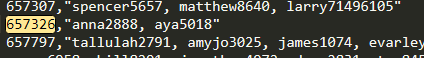

Sempre nel file loans_lenders.csv accade che per lo stesso prestito il nome di un utente venga ripetuto più volte, non è chiaro se questo è voluto.<br>
In questo caso _gmct_